AUC: 0.9783602846662289
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2341
           1       0.89      0.80      0.84       659

    accuracy                           0.93      3000
   macro avg       0.92      0.88      0.90      3000
weighted avg       0.93      0.93      0.93      3000



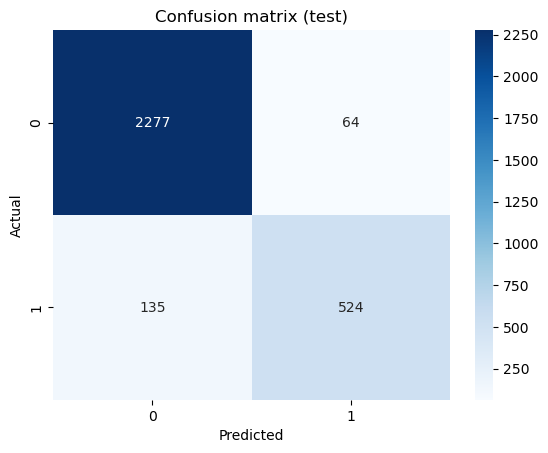

In [2]:
#Final evaluation on test set (run first)

import pandas as pd, numpy as np, joblib
from sklearn.metrics import (roc_auc_score, classification_report,
                             confusion_matrix, precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns

# load data + model
X_test = pd.read_csv("data/X_test.csv")
y_test = pd.read_csv("data/y_test.csv").squeeze()
final_model = joblib.load("models/final_day5_bestmodel.pkl")

# Predictions
y_proba_test = final_model.predict_proba(X_test)[:,1]
y_pred_test = (y_proba_test >= 0.5).astype(int)   # default threshold

# Basic metrics
print("AUC:", roc_auc_score(y_test, y_proba_test))
print(classification_report(y_test, y_pred_test))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion matrix (test)')
plt.show()


In [4]:
# Threshold selection & business metric

thresholds = np.linspace(0.01, 0.99, 99)
results = []
for t in thresholds:
    pred = (y_proba_test >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    # business metric example: profit = revenue_per_good*TP - loss_per_default*FP
    # define your numbers:
    revenue_per_good = 1000   # placeholder
    loss_per_default = 5000   # placeholder
    profit = tp * revenue_per_good - fp * loss_per_default
    results.append((t, roc_auc_score(y_test, y_proba_test), precision_score(y_test, pred, zero_division=0),
                    recall_score(y_test, pred, zero_division=0), profit))
res_df = pd.DataFrame(results, columns=['threshold','auc','precision','recall','profit'])
best = res_df.loc[res_df['profit'].idxmax()]
best


threshold         0.770000
auc               0.978360
precision         0.973913
recall            0.679818
profit       388000.000000
Name: 76, dtype: float64

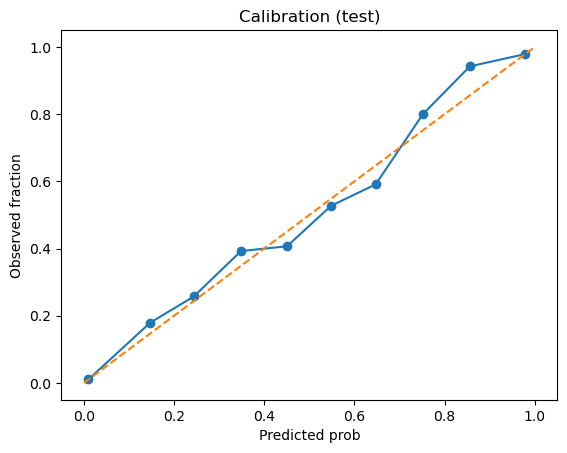

In [6]:
#Final calibration check (optional but useful)


from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_test, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], '--')
plt.title('Calibration (test)')
plt.xlabel('Predicted prob')
plt.ylabel('Observed fraction')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'reports/fig_shap_summary_bar.png'

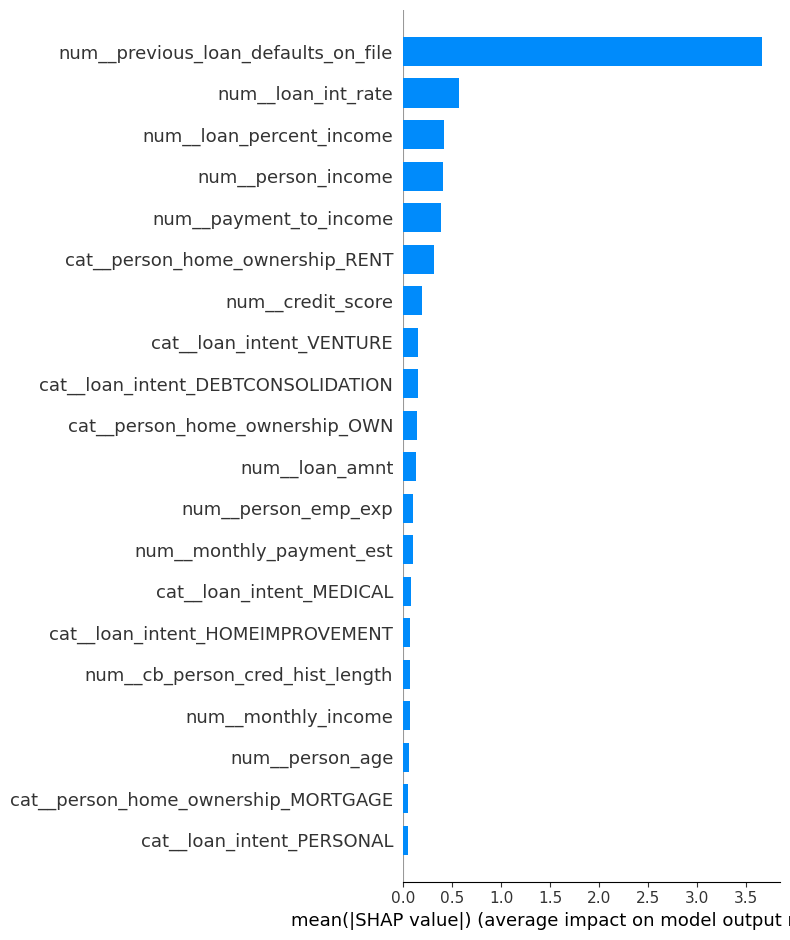

In [7]:
# Final SHAP visuals (global + 2 example locals)

import shap
explainer = shap.TreeExplainer(final_model.named_steps['model'])
# get transformed training data used earlier (or use some baseline)
X_train = pd.read_csv("data/X_train.csv")
X_train_tr = final_model.named_steps['preprocess'].transform(X_train)
shap_values = explainer.shap_values(X_train_tr)

# get feature names and make DataFrame
feat_names = final_model.named_steps['preprocess'].get_feature_names_out()
X_train_tr_df = pd.DataFrame(X_train_tr, columns=feat_names)

# summary (bar) - save fig
shap.summary_plot(shap_values, X_train_tr_df, plot_type="bar", show=False)
plt.savefig("reports/fig_shap_summary_bar.png", bbox_inches='tight', dpi=150)
plt.close()

# two local explanations (waterfall) for two sample indices (0 and 1)
for i, idx in enumerate([0,1]):
    sv = shap_values[i] if isinstance(shap_values, np.ndarray) else shap_values.values[i]
    shap.plots.waterfall(shap.Explanation(values=sv, base_values=explainer.expected_value, data=X_train_tr_df.iloc[i], feature_names=feat_names), show=False)
    plt.savefig(f"reports/fig_shap_waterfall_{i}.png", bbox_inches='tight', dpi=150)
    plt.close()
